** Import Libraries **

In [2]:
## Import libraries
from ast import literal_eval
import os, glob, pandas as pd
import string, re
import numpy as np
from tqdm import tqdm
from collections import Counter
import numbers
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from string import ascii_lowercase
import os 
import glob
import re
import requests
import shutil
import pandas as pd
import time
from nltk import ngrams
from operator import itemgetter
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.figure import Figure

In [3]:
os.chdir("C://Users//Ruben//Documents//GitHub//dhl-ads//resources")
df = pd.read_csv('total_results.csv')

In [41]:
def GetOccYear(df, year, occ):
    
    d = df[df.date.astype(str).str[0:4] == year]
    
    docc = d[(d['oc'] == occ)]
    docc_res = docc[(docc['ex_qual'] != "na") | (docc['ex_num'] !=  "na") | (docc['ex_nonnum'] != "na")]
    
    if len(docc) != 0:
        s = len(docc_res) / len(docc) * 100

        #print(str(len(docc_res)) + " instances")
        #print(str(round(s)) + "% of " + occ + " instances have results in the year " + str(year))
        return s

In [43]:
for i in sorted(list(set(df.date.astype(str).str[0:4]))):
    GetOccYear(df, i, 'boekhandelaar')

** Get Information on Occupations Extracted **

In [44]:
# 1. Creat Dictionary with Occupations and the Years in which they appear

dict_oc_year = dict()

for oc in list(set(df['oc'])):
    t = df[df['oc'] == oc]
    list_year = sorted(list(set(t.date.astype(str).str[0:4])))
    dict_oc_year.update({oc:list_year})

# We can use this to remove occupations that don't occur in every year
print(str(round(len([o for o,ly in dict_oc_year.items() if len(ly) < 10]) / len(dict_oc_year.keys()) * 100)) + '% of the occupations occurs every year')

77% of the occupations occurs every year


In [45]:
# 2. Create a DataFrame with Information on the share of observations / occupation that have information concerning wages
counts_occ = dict(Counter(df['oc']))
d = df

df_occ_hits = pd.DataFrame()

for occ in list(set(d['oc'])):
    dt = d
    docc = dt[(dt['oc'] == occ)]
    docc_res = docc[(docc['ex_qual'] != "na") | (docc['ex_num'] !=  "na") | (docc['ex_nonnum'] != "na")]
    
    if len(docc_res) != 0:
        s = len(docc_res) / len(docc) * 100
    if len(docc_res) == 0:
        s = 0
    
    c = counts_occ[occ]
    
    t = pd.DataFrame([occ, s,c]).T
    df_occ_hits= df_occ_hits.append(t)
df_occ_hits.columns = ['oc', 'score', 'count']

In [46]:
# The wages with the highest score have the most results and are likely to feature in job ads.
# some wages occur only incidentally. Therefore, selecting only the ones with a significant number of observations makes sense
occupation_selection = df_occ_hits[(df_occ_hits['score'] > 50) & (df_occ_hits['count'] > 200)]

** Investigate Qualitative Indicators **

In [48]:
list_qual = list(df[df['ex_qual'] != "na"]['ex_qual'])
list_qual = [literal_eval(l) for l in list_qual]
list_qual = [item for sublist in list_qual for item in sublist]

In [49]:
qual_counts = dict(Counter(list_qual))

In [58]:
for occ in occupation_selection['oc']:
    occ_subset = df[df['oc'] == occ]
    tmp_list_qual = list(occ_subset[occ_subset['ex_qual'] != "na"]['ex_qual'])
    tmp_list_qual = [literal_eval(l) for l in tmp_list_qual]
    tmp_list_qual = [item for sublist in tmp_list_qual for item in sublist]
    top_qual = list(dict(Counter(tmp_list_qual).most_common(5)).keys())
    if top_qual[0] == "naar_bekwaamheid" or top_qual[0] == "naar_bekwaamheden":
        print(occ + " | top 10: " + ", ".join(top_qual))

directeur | top 10: naar_bekwaamheden, naar_bekwaamheid, hoog_loon, goed_loon, goed_salaris
correspondentie | top 10: naar_bekwaamheid, naar_bekwaamheden, ruim_salaris, goed_salaris, hoog_salaris
boekhouder | top 10: naar_bekwaamheid, ruim_salaris, goed_salaris, behoorlijk_salaris, hoog_salaris
klerk | top 10: naar_bekwaamheid, behoorlijk_salaris, naar_bekwaamheden, goed_salaris, ruim_salaris
hulponderwijzer | top 10: naar_bekwaamheden, naar_bekwaamheid, goed_salaris, ruim_salaris, behoorlijk_salaris
secondant | top 10: naar_bekwaamheden, ruim_salaris, naar_bekwaamheid, goed_salaris, behoorlijk_salaris
reiziger | top 10: naar_bekwaamheid, goed_salaris, ruim_salaris, hoog_salaris, naar_bekwaamheden
leerling | top 10: naar_bekwaamheid, goed_loon, naar_bekwaamheden, goed_salaris, hoog_loon
ondermeester | top 10: naar_bekwaamheden, naar_bekwaamheid, behoorlijk_salaris, goed_salaris, ruim_salaris
gouvernante | top 10: naar_bekwaamheden, hoog_salaris, goed_salaris, naar_bekwaamheid, ruim_sal

In [65]:
sdf_share_qual = pd.DataFrame()

for year in sorted(list(set(df.date.astype(str).str[0:4]))):
    subset = df[df.date.astype(str).str[0:4] == year]
    len_total_subset = len(subset)
    len_qual_subset = len(subset[subset['ex_qual'] != "na"])
    
    sh = round(len_qual_subset / len_total_subset * 100, 3)
    t = pd.DataFrame([year, sh]).T
    sdf_share_qual = sdf_share_qual.append(t)
sdf_share_qual.columns = ['Year', '% of ads w/Qualitative Indicators']
sdf_share_qual['Year'] = sdf_share_qual['Year'].astype(int)

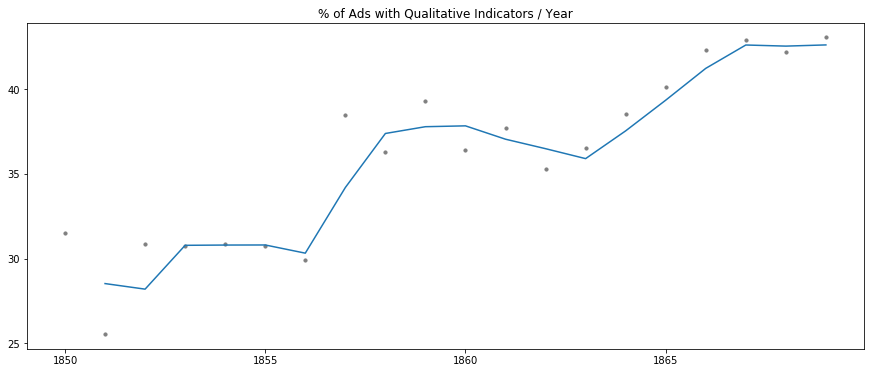

In [72]:
x_values = sdf_share_qual['Year']
y_values = sdf_share_qual['% of ads w/Qualitative Indicators']

color_point = "grey"
rm = sdf_share_qual['% of ads w/Qualitative Indicators'].rolling(window=2).mean()
plt.figure(figsize=(15,6))
plt.locator_params(integer=True)

mpl_fig = plt.scatter(x = x_values, y = y_values, c = color_point, s = 10)
plt.plot(x_values, rm)
plt.title("% of Ads with Qualitative Indicators / Year")
plt.show()

In [87]:
### Stream Graph of Indicator Frequency

sdf_stream_qual = pd.DataFrame()

for year in sorted(list(set(df.date.astype(str).str[0:4]))):
    subset = df[(df.date.astype(str).str[0:4] == year) & (df['ex_qual'] != "na")]

    counted_subset = list(subset[subset['ex_qual'] != "na"]['ex_qual'])
    counted_subset = [literal_eval(l) for l in counted_subset]
    counted_subset = [item for sublist in counted_subset for item in sublist]
    counted_subset = dict(Counter(counted_subset))
    
    list_year = []
    
    for ind in list(qual_counts.keys()):
        if ind not in list(counted_subset.keys()):
            c = 0
            list_year.append(c) 
        else:
            c = counted_subset[ind] / len(subset)
            list_year.append(c)  
            
    list_year = [int(year)] + list_year
    list_year = pd.DataFrame(list_year).T
    sdf_stream_qual = sdf_stream_qual.append(list_year)

In [88]:
sdf_stream_qual.columns = ['year'] + list(qual_counts.keys())

(array([1845., 1850., 1855., 1860., 1865., 1870.]),
 <a list of 6 Text xticklabel objects>)

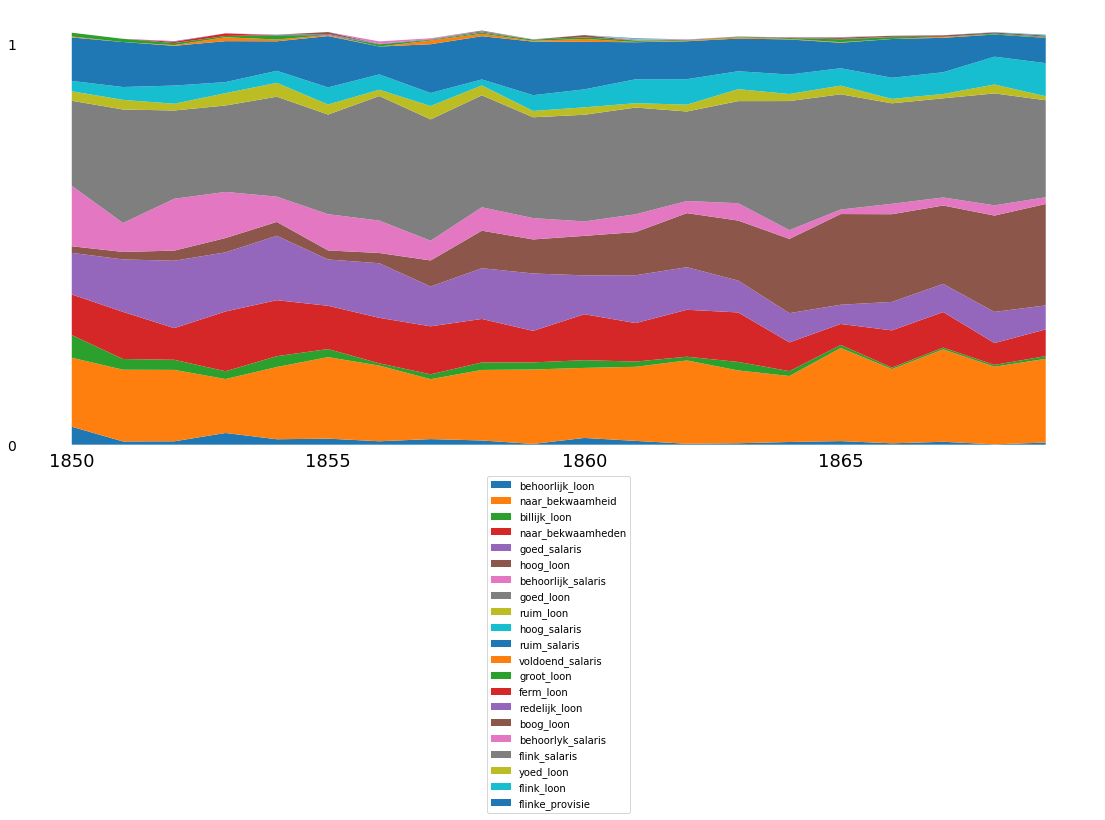

In [93]:
x_lab = "Years"
y_lab = "Share of All Ads w/Qualitative Indicators"
    
fig, ax = plt.subplots(facecolor='white',figsize=(24, 8))
labels = list(sdf_stream_qual.columns[1:])
plt.stackplot(list(sdf_stream_qual.year), *[sdf_stream_qual[col] for col in labels])
ax.set_facecolor("white")
box = ax.get_position()
    #hfont = {'fontname':'Helvetica'}

ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
lgd = ax.legend(labels, loc='upper center', bbox_to_anchor=(0.5, -0.06))
    
for ticks in ax.xaxis.get_ticklines() + ax.yaxis.get_ticklines():
    ticks.set_color("white")
for pos in ['top', 'bottom', 'right', 'left']:
    ax.spines[pos].set_edgecolor("white")
plt.locator_params(integer=True)

plt.yticks(fontsize=14)
plt.xticks(fontsize=18)

#plt.title(title, fontsize=22)

** Make Density Plot of Observed Wages / Occupation **

In [79]:
def PlotDensityWage(df, list_wages, limit):
    list_oc = []
    for o in list_wages:
        subset_oc = df[(df['oc'] == o)]
        l = list(subset_oc[(subset_oc['ex_num'] != 'na') & (subset_oc['ex_num'].astype(str).str.isdigit())]['ex_num'])
        print(str(round(len(l) / len(subset_oc) * 100)) + "% of " + o + " observations has numbers")
        l = [int(x) for x in l if int(x) < limit]
        print("total n=" + str(len(l)))
        list_oc.append(l)
    doc = pd.DataFrame(list_oc).T
    doc.columns = list_wages
    doc.plot.kde(ind=list(range(0,400,10)))

54% of secondant observations has numbers
total n=387
17% of bediende observations has numbers
total n=185
32% of keukenmeid observations has numbers
total n=210
50% of onderwijzer observations has numbers
total n=206
11% of jufvrouw observations has numbers
total n=82
16% of knecht observations has numbers
total n=32


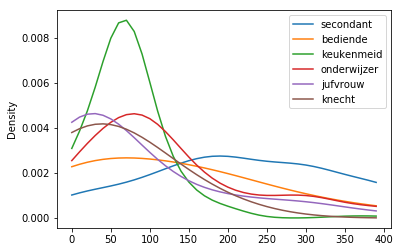

In [81]:
PlotDensityWage(df, ['secondant', 'bediende', 'keukenmeid', 'onderwijzer', 'jufvrouw', 'knecht'], 2000)

** Plot Diachronic Wages / Occupation **

In [119]:
def PlotDiaWage(df, occ, limit):
    list_wage_year = []
    subset_oc = df[(df['oc'] == occ)]
    
    for y in sorted(list(set(df.date.astype(str).str[0:4]))):
        subset_year = subset_oc[(subset_oc.date.astype(str).str[0:4] == y)]
        l = list(subset_year[(subset_year['ex_num'] != 'na') & (subset_year['ex_num'].astype(str).str.isdigit())]['ex_num'])
        print(str(round(len(l) / len(subset_year) * 100)) + "% of " + occ + " observations has numbers")
        #l = [int(x) for x in l if int(x) < limit]
        print("total n=" + str(len(l)))
        
        #average = sum([int(x) for x in l]) / len(l)
        list_wage_year.append(l)
    list_wage_year = pd.DataFrame(list_wage_year).T
    list_wage_year.columns = [sorted(list(set(df.date.astype(str).str[0:4])))]
    list_wage_year = pd.melt(bp) 
    list_wage_year.columns = ['per', 'w']
    list_wage_year = list_wage_year.dropna()
    list_wage_year['w'] = list_wage_year['w'].astype(int)
    return list_wage_year

In [120]:
bp = PlotDiaWage(df, 'keukenmeid')

21% of keukenmeid observations has numbers
total n=9
29% of keukenmeid observations has numbers
total n=14
28% of keukenmeid observations has numbers
total n=19
26% of keukenmeid observations has numbers
total n=17
19% of keukenmeid observations has numbers
total n=10
32% of keukenmeid observations has numbers
total n=10
38% of keukenmeid observations has numbers
total n=21
27% of keukenmeid observations has numbers
total n=21
42% of keukenmeid observations has numbers
total n=46
38% of keukenmeid observations has numbers
total n=45


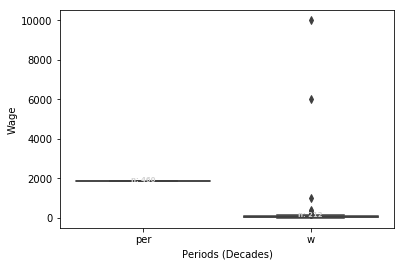

In [121]:
ax = sns.boxplot(x="per", y="w", data=bp)

# Calculate number of obs per group & median to position labels
medians = bp.groupby(['per'])['w'].median().values
nobs = bp['per'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]

# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.03, nobs[tick],
    horizontalalignment='center', size='x-small', color='lightgrey', weight='semibold')
    
ax.set(xlabel='Periods (Decades)', ylabel='Wage')
ax = ax.get_figure()

In [15]:
def PlotDiaHist(occ, limit):
    list_wage_year = []
    subset_oc = df[(df['true_occupation'] == occ)]

    for y in sorted(list(set(df.date.astype(str).str[0:4]))):
        subset_year = subset_oc[(subset_oc.date.astype(str).str[0:4] == y)]
        l = list(subset_year[(subset_year['ex_num'] != 'na') & (subset_year['ex_num'].astype(str).str.isdigit())]['ex_num'])
        #print(str(round(len(l) / len(subset_year) * 100)) + "% of " + 'keukenmeid' + " observations has numbers")
        l = [int(x) for x in l if int(x) < limit]
        #print("total n=" + str(len(l)))

        #average = sum([int(x) for x in l]) / len(l)
        list_wage_year.append(l)
    list_wage_year = pd.DataFrame(list_wage_year).T
    list_wage_year.columns = [sorted(list(set(df.date.astype(str).str[0:4])))]
    list_wage_year = pd.melt(list_wage_year) 
    list_wage_year.columns = ['per', 'w']
    list_wage_year = list_wage_year.dropna()
    list_wage_year['w'] = list_wage_year['w'].astype(int)
    bp = list_wage_year
    bp['per'] = bp['per'].astype(int)

    sns.set(rc={'figure.figsize':(30,10)})


    ax = sns.boxplot(x="per", y="w", data=bp)

    # Calculate number of obs per group & median to position labels
    medians = bp.groupby(['per'])['w'].median().values
    nobs = bp['per'].value_counts().values
    nobs = [str(x) for x in nobs.tolist()]
    nobs = ["n: " + i for i in nobs]

    # Add it to the plot
    pos = range(len(nobs))
    for tick,label in zip(pos,ax.get_xticklabels()):
        ax.text(pos[tick], medians[tick] + 0.03, nobs[tick],
        horizontalalignment='center', size='small', color='w', weight='semibold')

    ax.set(xlabel='Periods (Decades)', ylabel='Wage')
    ax = ax.get_figure()

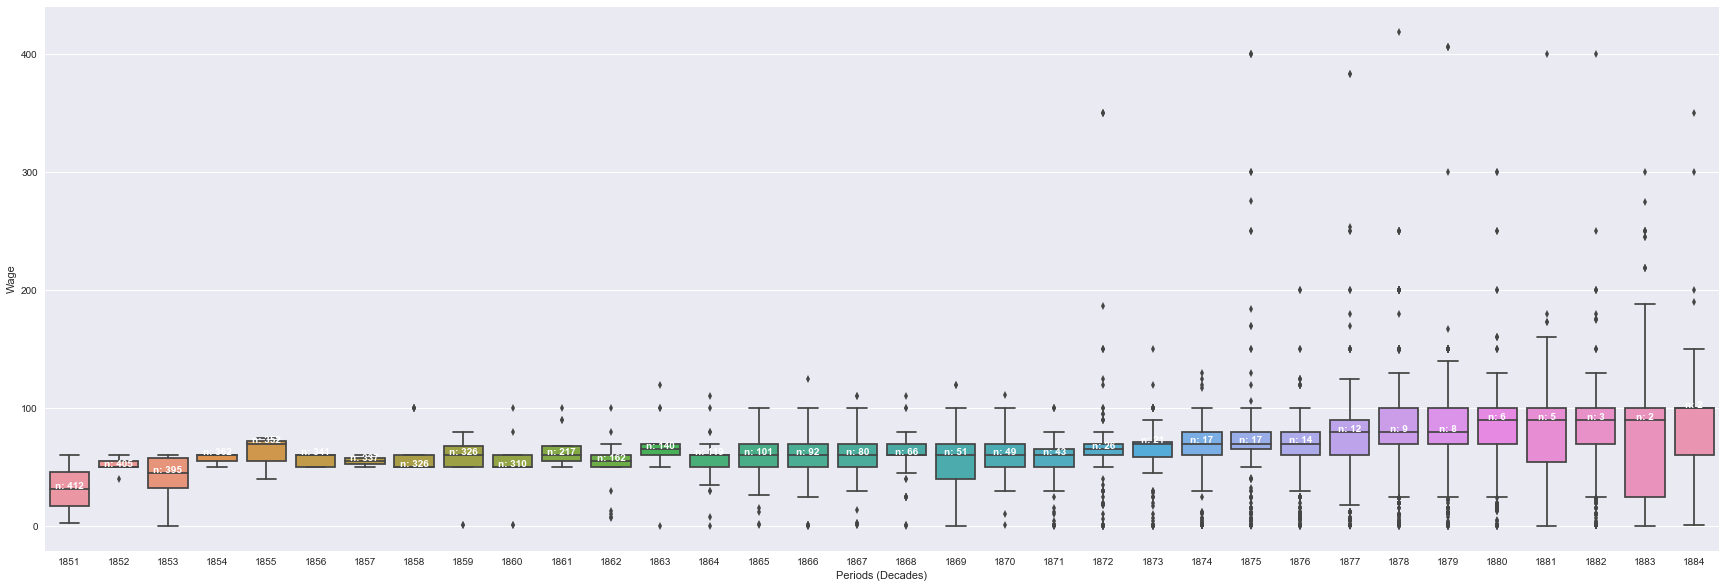

In [28]:
PlotDiaHist('bienstbode', 500)

In [26]:
Counter(list(df['true_occupation'])).most_common(20)

[('boekhandelaar', 30680),
 ('pletter', 29934),
 ('lienst', 27903),
 ('hoom', 26986),
 ('zaar', 25313),
 ('dkost', 18362),
 ('keukenmeid', 15949),
 ('fetuigen', 15498),
 ('bienstbode', 14900),
 ('ueer', 12305),
 ('koker', 12245),
 ('hniswerk', 10127),
 ('jbediende', 9000),
 ('juflrouw', 8672),
 ('meidk', 6705),
 ('werker', 6155),
 ('weekmeid', 5842),
 ('hulponderwijzer', 4964),
 ('strijker', 4544),
 ('borgemeester', 4302)]

In [29]:
df.head()

,id,date,oc,window,image_url,occ_index,ex_qual,ex_num,true_occupation
0,24aaaak,1850/01/01 00:00:00,dienstbode,op het land jy ln de nabijheid van zwolle eene...,http://imageviewer.kb.nl/ImagingService/imagin...,224,['behoorlijk_loon'],na,bienstbode
1,24aaaal,1850/01/01 00:00:00,meid,land jy ln de nabijheid van zwolle eene piotes...,http://imageviewer.kb.nl/ImagingService/imagin...,226,['behoorlijk_loon'],na,meidk
2,24aaaam,1850/01/01 00:00:00,werken,eene pioteské tansche dienstbode voor meid all...,http://imageviewer.kb.nl/ImagingService/imagin...,233,['behoorlijk_loon'],na,werker
3,24aaaan,1850/01/01 00:00:00,liefst,zindelijk en vlug kan werken en wasschen legen...,http://imageviewer.kb.nl/ImagingService/imagin...,241,['behoorlijk_loon'],na,lienst
4,24aaaao,1850/01/01 00:00:00,isten,vlug kan werken en wasschen legen een behoorli...,http://imageviewer.kb.nl/ImagingService/imagin...,243,['behoorlijk_loon'],na,ioten


In [32]:
master_dict = dict()

for y in tqdm(sorted(list(set(df.date.astype(str).str[0:4])))):
    subset_year = df[(df.date.astype(str).str[0:4] == y)]
    
    dict_year = dict()
    
    for oc in list(set(subset_year['true_occupation'])):
        dict_year.update({oc:[list(subset_year[subset_year['true_occupation'] == oc]['ex_qual']),list(subset_year[subset_year['true_occupation'] == oc]['ex_num'])]})
        
    master_dict.update({y:dict_year})

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [02:18<00:00,  8.32s/it]


In [33]:
master_dict['1855']

{'militair': [['na', 'na'], ['4', 'na']],
 'expeditie': [["['billijk_salaris']", 'na', "['naar_bekwaamheid']", 'na'],
  ['na', 'na', 'na', 'na']],
 'kamenier': [["['hoog_salaris']", 'na'], ['na', 'na']],
 'koker': [['na',
   'na',
   "['goed_salaris']",
   'na',
   "['goed_loon']",
   "['goed_loon']",
   "['goed_loon']",
   'na',
   'na',
   "['naar_bekwaamheid']",
   'na',
   "['goed_loon']",
   "['ruim_salaris']",
   'na',
   "['naar_bekwaamheid']",
   "['naar_bekwaamheid']",
   'na',
   "['naar_bekwaamheid']",
   "['hoog_loon']",
   "['hoog_loon']",
   "['hoog_loon']",
   'na',
   'na',
   'na',
   "['goed_loon']",
   'na'],
  ['na',
   'van60',
   '10',
   'na',
   'na',
   'na',
   '50',
   '60',
   'ƒ6o',
   'na',
   'tegen60',
   'na',
   'na',
   '70',
   '75',
   'na',
   'na',
   'na',
   'na',
   'na',
   'na',
   '60',
   'vijftig',
   'vijftig',
   'na',
   'ƒ5o']],
 'zilversmid': [["['hoog_loon']", "['goed_loon']"], ['na', 'na']],
 'boekdrukker': [['na',
   'na',
   "['na

In [41]:
ml = []

for y in sorted(list(set(df.date.astype(str).str[0:4]))):
    tmp = master_dict[y]
    
    for k,v in tmp.items():
        vn = v[0] + v[1]
        tot = len(vn)
        totres = len([v for v in vn if v != "na"])
        share = round(totres / tot * 100, 3)
        ml.append([k, y,tot,share])

In [44]:
df_res = pd.DataFrame(ml, columns = ['occupation', 'year', 'num_observations', 'share_with_results'])
os.chdir("C://Users//Ruben//Documents//GitHub//dhl-ads//resources")
df_res.to_csv('occupation_results.csv',index=False)

In [47]:
df_res = df_res.sort_values(['share_with_results'],ascending=False)
df_res = df_res[df_res['num_observations'] > 100]

In [48]:
df_res

,occupation,year,num_observations,share_with_results
11002,onderwijzer,1866,138,61.594
11142,handwerker,1866,124,61.290
20786,metselaar,1876,106,60.377
21324,noodhulp,1876,184,60.326
17583,eindermeid,1873,104,59.615
27074,acent,1881,114,58.772
20204,maagd,1875,194,58.247
30246,seconöant,1883,178,57.865
27501,hoom,1881,3456,57.292
18981,borgemeester,1874,262,57.252
